<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting*, *random forest*.
* Redes Neuronales Convolucionales vs *Feed Forward*
* Aprendizaje no supervisado: *hidden models*
* Aprendizaje sobre secuencias
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (11:55 hrs)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Calidad de un vino  
[2.](#segundo) Redes Convolucionales sobre imágenes  
[3.](#tercero) Cadenas de Markov

In [2]:
import numpy as np
import keras
import pandas as pd
#import urllib2,re
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as SVM
from sklearn.tree import DecisionTreeClassifier as Tree
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

/home/jaime/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1) Calidad de un vino


## A)
Carge los dos dataset en un único dataframe de pandas, además de agregar una columna indicando si es vino tinto o blanco. Describa el dataset a trabajar.

In [9]:
import pandas as pd
df_red = pd.read_csv("winequality-red.csv",sep=";")
tinto = len(df_red) 
df_white = pd.read_csv("winequality-white.csv",sep=";")
blanco= len(df_white)
df = pd.concat([df_red,df_white], axis=0)
lista=[]
for i in range(tinto):
    lista.append(0)
for i in range(blanco):
    lista.append(1)
#genere atributo 'tipo'
df.loc[:,'tipo'] = lista
print(df.shape)
df.head(10)

(6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,tipo
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,0
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,0


El dataset tiene 6497 datos, y 13 columnas, las columnas son las siguientes:

- fixed acidity: 
- citric acidity: 
- residual acidity: 
- residual sugar: 
- chlorides: 
- free sulfur dioxide: 
- total sulfur dioxide: 
- density: 
- pH: pH del vino
- sulphates: 
- alcohol: grado alcohólico
- quality: calidad del vino
- tipo: Tipo de cepa

## B) 
Aborde este problema como si fuera de clasificación con multiples clases para predecir el valor de calidad de un vino, es decir, utilice las distintas caracterı́sticas fisioquı́micas presentes en los datos para estimar la etiqueta ¿Cuántas clases son y cuántos ejemplos hay por clase? ¿Qué sucede con predecir si un vino tiene calidad mínima (0) o máxima(10)? Además para el propósito académico de esta actividad cree un conjunto de pruebas (20%) para evaluar la generalización final del modelo y otro de validación (20%) si estima conveniente.

In [10]:
clases = df.groupby(["quality"])
clases.count()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,tipo
quality,,,,,,,,,,,,
3,30,30,30,30,30,30,30,30,30,30,30,30
4,216,216,216,216,216,216,216,216,216,216,216,216
5,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138
6,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836
7,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079
8,193,193,193,193,193,193,193,193,193,193,193,193
9,5,5,5,5,5,5,5,5,5,5,5,5


Hay en total 7 clases en el dataset, calidad 3 a la 9. Como el problema es de clasificación de multiples categorias, este problema solo asociará un input con una esas calidades. Hay 30 casos con calidad 3, 216 con calidad 4, 2138 con calidad 5, 2836 con calidad 6, 1079 con calidad 7, 193 con calidad 8 y 5 con calidad 9. Era de esperarse que la mayoria de los datos estuviesen en las categorias del "medio". Si se intenta predecir un vino de calidad 0 , este debería parar a la categoria de los vinos con calidad 3. Mientras que los vinos de calidad 10 , deberían pasar a los vinos de la calidad 9. En terminos simples, se categorizan.

In [11]:
y = df["quality"].values
df1=df.drop(columns=["quality"])
split = int(len(df)*0.2) 
X_train = df1[split:-split]
X_test  = df1[:split]
X_val = df1[-split:]
Y_train = y[split:-split]
Y_test  = y[:split]
Y_val = y[-split:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(3899, 12)
(1299, 12)
(1299, 12)


## C) 
Entrene un solo Árbol de Clasificación de múltiples niveles para resolver el problema. Defina un Árbol no regularizado (como el que no tiene límites en su profundidad) y otro Árbol regularizado (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar split o el número mínimo de datos en cada hoja), recuerde que las decisiones no pueden ser basadas mirando el conjunto de pruebas. Debido al desbalanceo que se produce en las clases mida la métrica F1-score [2] sobre el conjunto de entrenamiento y de pruebas.

In [12]:
#Modelo no regularizado
model1 = Tree()
#model1.set_params(criterion='gini',splitter='best')
model1.fit(X_train,Y_train)
print("Train Accuracy: ",model1.score(X_train,Y_train))
print("Test Accuracy: ",model1.score(X_test,Y_test))
print("Val Accuracy: ",model1.score(X_val,Y_val))

Train Accuracy:  1.0
Test Accuracy:  0.45573518090839105
Val Accuracy:  0.4210931485758276


In [14]:
#Modelo regularizado
model2 = Tree()
for i in range(1,10):
    C=i
    print("Altura: ",i)
    model2.set_params(max_depth=C,criterion='gini',splitter='best')
    model2.fit(X_train,Y_train)
    print("Train Accuracy: ",model2.score(X_train,Y_train))
    print("Test Accuracy: ",model2.score(X_test,Y_test))
    print("Val Accuracy: ",model2.score(X_val,Y_val))

Altura:  1
Train Accuracy:  0.4283149525519364
Test Accuracy:  0.39414934565050036
Val Accuracy:  0.5034642032332564
Altura:  2
Train Accuracy:  0.49166452936650423
Test Accuracy:  0.5304080061585835
Val Accuracy:  0.5719784449576597
Altura:  3
Train Accuracy:  0.5165427032572455
Test Accuracy:  0.5327174749807544
Val Accuracy:  0.5850654349499615
Altura:  4
Train Accuracy:  0.5298794562708387
Test Accuracy:  0.552732871439569
Val Accuracy:  0.588144726712856
Altura:  5
Train Accuracy:  0.5583482944344704
Test Accuracy:  0.5373364126250962
Val Accuracy:  0.5465742879137798
Altura:  6
Train Accuracy:  0.580918184149782
Test Accuracy:  0.5103926096997691
Val Accuracy:  0.552732871439569
Altura:  7
Train Accuracy:  0.605539882021031
Test Accuracy:  0.5019245573518091
Val Accuracy:  0.5196304849884527
Altura:  8
Train Accuracy:  0.6404206206719671
Test Accuracy:  0.5050038491147036
Val Accuracy:  0.5065434949961509
Altura:  9
Train Accuracy:  0.6750448833034112
Test Accuracy:  0.4888375673

La mejor altura encontrada fue 4, que tuvo un error de testing de 0.55 y error de training de 0.53.

In [15]:
from sklearn.metrics import f1_score
print("f1_score del modelo no regularizado: ",f1_score(Y_test, model1.predict(X_test), average="micro" ))
print("f1_score del modelo regularizado: ",f1_score(Y_test, model2.predict(X_test), average="micro"))

f1_score del modelo no regularizado:  0.455735180908391
f1_score del modelo regularizado:  0.4888375673595073


## D)
Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en c)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro.

Lo que se esperaria que pasara es que el modelo no regularizado provoque overfitting, ya que si bien bagging funciona bien en modelos no regularizados, este puede tener overfitting si se esta resolviendo un problema multi-label como este.

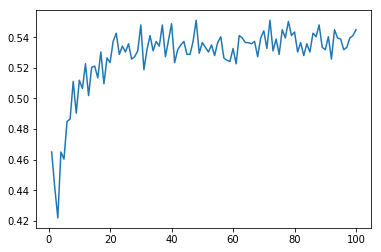

In [16]:
#No Regularizado
from sklearn.ensemble import BaggingClassifier
estimador_nr=[]
f1_nr=[]

for i in range(1,101):
    estimador_nr.append(i)
    model3 = BaggingClassifier(base_estimator=Tree(), n_estimators=i, n_jobs=-1)
    model3.fit(X_train,Y_train)
    y_pred = model3.predict(X_test)
    f1_nr.append(f1_score(Y_test, y_pred, average="micro") )

plt.plot(estimador_nr,f1_nr)


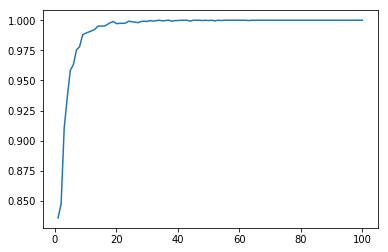

In [40]:
#No Regularizado
from sklearn.ensemble import BaggingClassifier
estimador_nr=[]
f1_nr=[]

for i in range(1,101):
    estimador_nr.append(i)
    model3 = BaggingClassifier(base_estimator=Tree(), n_estimators=i, n_jobs=-1)
    model3.fit(X_train,Y_train)
    y_pred = model3.predict(X_train)
    f1_nr.append(f1_score(Y_train, y_pred, average="micro") )

plt.plot(estimador_nr,f1_nr)


Si bien el modelo no regularizado tiende a mejorar el score en testing(de 0.4 a 0.55 aproximadamente), hay una alta tendencia a overfitting, observado por el gráfico de training que sube rapidamente a 1.

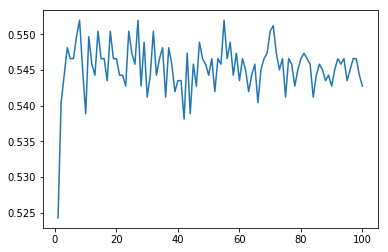

In [17]:
#Regularizado
from sklearn.ensemble import BaggingClassifier
estimador_r=[]
f1_r=[]

for i in range(1,101):
    estimador_r.append(i)
    model4 = BaggingClassifier(base_estimator=Tree(max_depth=4,criterion='gini',splitter='best'), n_estimators=i, n_jobs=-1)
    model4.fit(X_train,Y_train)
    y_pred = model4.predict(X_test)
    f1_r.append(f1_score(Y_test, y_pred, average="micro") )

plt.plot(estimador_r,f1_r)

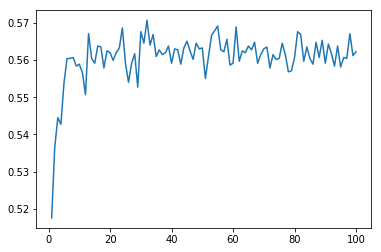

In [41]:
#Regularizado
from sklearn.ensemble import BaggingClassifier
estimador_r=[]
f1_r=[]

for i in range(1,101):
    estimador_r.append(i)
    model4 = BaggingClassifier(base_estimator=Tree(max_depth=4,criterion='gini',splitter='best'), n_estimators=i, n_jobs=-1)
    model4.fit(X_train,Y_train)
    y_pred = model4.predict(X_train)
    f1_r.append(f1_score(Y_train, y_pred, average="micro") )

plt.plot(estimador_r,f1_r)

Si bien en testing el f score sube mas lentamente que en el no regularizado, este error no esta sujeto a overfitting en el entrenamiento, ya que en entrenamiento el f score sube hasta un valor de 0.57. Esto significa que el modelo fue mejor cuando se usó un árbol regularizado.

## E)
Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en c) ¿Se visualiza overfitting? ¿Qué técnica se utiliza, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

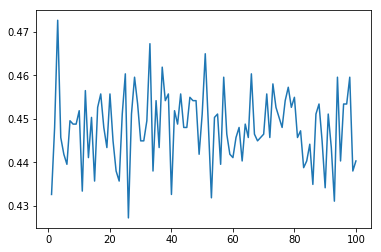

In [19]:
from sklearn.ensemble import AdaBoostClassifier
estimador_nr=[]
f1_nr=[]
for i in range(1,101):
    estimador_nr.append(i)
    model5 = AdaBoostClassifier(base_estimator=Tree(), n_estimators=i)
    model5.fit(X_train,Y_train)
    y_pred = model5.predict(X_test)
    f1_nr.append(f1_score(Y_test, y_pred, average="micro") )

plt.plot(estimador_nr,f1_nr)

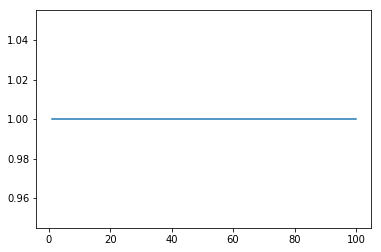

In [42]:
from sklearn.ensemble import AdaBoostClassifier
estimador_nr=[]
f1_nr=[]
for i in range(1,101):
    estimador_nr.append(i)
    model5 = AdaBoostClassifier(base_estimator=Tree(), n_estimators=i)
    model5.fit(X_train,Y_train)
    y_pred = model5.predict(X_train)
    f1_nr.append(f1_score(Y_train, y_pred, average="micro") )

plt.plot(estimador_nr,f1_nr)

Claramente hay un overfitting, ya que el fscore se mantuvo como 1 para todo estimador en el conjunto de entrenamiento, además tampoco es bueno el resultado erratico(que pareciera tender a un mismo valor) que se presentó en testing. Comparando con lo realizado en el item D), ambos casos en el modelo no regularizado provocaron overfitting, pero en este caso es mas severo que en D).

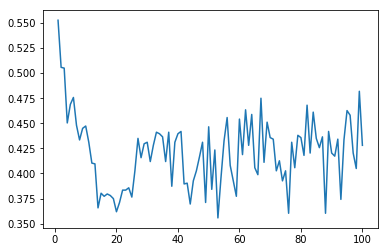

In [21]:
from sklearn.ensemble import AdaBoostClassifier
estimador_r=[]
f1_r=[]
for i in range(1,101):
    estimador_r.append(i)
    model6 = AdaBoostClassifier(base_estimator=Tree(max_depth=4,criterion='gini',splitter='best'), n_estimators=i)
    model6.fit(X_train,Y_train)
    y_pred = model6.predict(X_test)
    f1_r.append(f1_score(Y_test, y_pred, average="micro") )

plt.plot(estimador_r,f1_r)

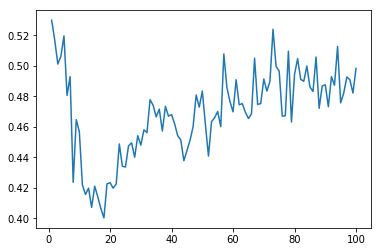

In [43]:
from sklearn.ensemble import AdaBoostClassifier
estimador_r=[]
f1_r=[]
for i in range(1,101):
    estimador_r.append(i)
    model6 = AdaBoostClassifier(base_estimator=Tree(max_depth=4,criterion='gini',splitter='best'), n_estimators=i)
    model6.fit(X_train,Y_train)
    y_pred = model6.predict(X_train)
    f1_r.append(f1_score(Y_train, y_pred, average="micro") )

plt.plot(estimador_r,f1_r)

Si bien el comportamiento es extraño(bajar y volver a subir), el modelo regularizado maneja mejor el overfitting, siendo los gráficos de training y test muy parecidos en términos de forma. En cuanto a valores se vuelve a repetir el mismo caso que en D, variando el fscore de testing muy poco en comparación al de training. La gran diferencia entre ambos es a forma de la curva de como se llega al fscore.

## F
Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen el F1-score de entrenamiento y de pruebas en función de este hiper-parámetro.

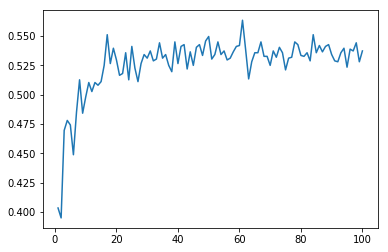

In [23]:
from sklearn.ensemble import RandomForestClassifier
estimador_nr=[]
f1_nr=[]
for i in range(1,101):
    estimador_nr.append(i)
    model5 = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    model5.fit(X_train,Y_train)
    y_pred = model5.predict(X_test)
    f1_nr.append(f1_score(Y_test, y_pred, average="micro") )

plt.plot(estimador_nr,f1_nr)

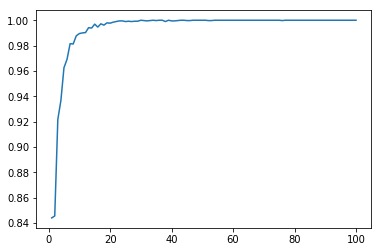

In [44]:
from sklearn.ensemble import RandomForestClassifier
estimador_nr=[]
f1_nr=[]
for i in range(1,101):
    estimador_nr.append(i)
    model5 = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    model5.fit(X_train,Y_train)
    y_pred = model5.predict(X_train)
    f1_nr.append(f1_score(Y_train, y_pred, average="micro") )

plt.plot(estimador_nr,f1_nr)

Para este caso se visualiza overfitting, ya que si bien los datos de test tienden a subir, los de training suben inmediatamente a 1, esto signfica que hubo un overfitting presente en el problema.

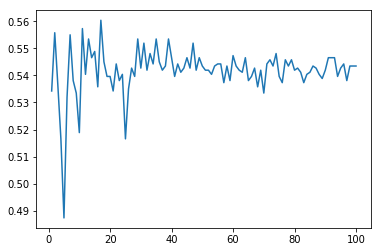

In [25]:
from sklearn.ensemble import RandomForestClassifier
estimador_r=[]
f1_r=[]
for i in range(1,101):
    estimador_r.append(i)
    model6 = RandomForestClassifier(n_estimators=i, max_depth=4,criterion='gini',n_jobs=-1)
    model6.fit(X_train,Y_train)
    y_pred = model6.predict(X_test)
    f1_r.append(f1_score(Y_test, y_pred, average="micro") )

plt.plot(estimador_r,f1_r)

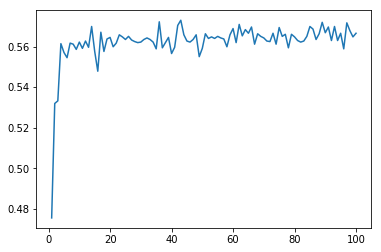

In [45]:
from sklearn.ensemble import RandomForestClassifier
estimador_r=[]
f1_r=[]
for i in range(1,101):
    estimador_r.append(i)
    model6 = RandomForestClassifier(n_estimators=i, max_depth=4,criterion='gini',n_jobs=-1)
    model6.fit(X_train,Y_train)
    y_pred = model6.predict(X_train)
    f1_r.append(f1_score(Y_train, y_pred, average="micro") )

plt.plot(estimador_r,f1_r)

No se visuliza overfitting, de hecho, la forma de los dos gráficos es muy parecida. El fscore en el caso de training sube rapidamente a su mejor valor (0.57 aproximadamente) y oscila por ahí. En el caso de test, el fscore baja a 0.49 y luego sube hasta 0.55 aproximadamente, esto significa que el crecimiento fue casi el mismo que en el de training.

## G
Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compárelo con el error calculado sobre el conjunto de pruebas y validación (o en su defecto cross validation).

In [26]:
oob_error = 1 - model6.oob_score_
test_error = 1- model6.score(X_test,Y_test)
val_error = 1- model6.score(X_val,Y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
print("Test error: ",test_error)

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'

## H
Entrene alguna otra máquina de aprendizaje, elegida por usted de entre todas las vistas en el curso, para resolver el problema. Elija los hiper-parámetros que estime convenientes intentando aumentar el F1-score obtenido por los algoritmos anteriores ¿Se logra una mejora? ¿Por qué?

In [72]:
model= SVM()
C = 10**-0.4
model.set_params(C=C,kernel='rbf')
model.fit(X_train,Y_train)
print("f1_score de testing del modelo : ",f1_score(Y_test, model.predict(X_test), average="micro"))
print("f1_score de training del modelo : ",f1_score(Y_train, model.predict(X_train), average="micro"))

f1_score de testing del modelo :  0.4341801385681293
f1_score de training del modelo :  0.6375993844575533


## I
Compare y analice las distintas maneras con las que se resolvió el problema definido en b), por ejemplo incluya las decisiones que conlleva y los resultados que reflejan.

En general, todas las técnicas(bagging, adaBoosting y randomForest) tuvieron overfitting en el caso del árbol no regularizado, esto se debe a que cuando se trabaja con un modelo de multiclase, los modelos no regularizados tienden a tener mas overfitting. Todos los análisis presentes se haran en torno al árbol regularizado.

En el primer caso, bagging, el gráfico de entrenamiento tuvo una subida en su fscore, sin embargo, el conjunto de test no tuvo una subida tan buena, debido a que del fscore inicial, solo se varió en aproximadamente en 0.025, en comparación al entrenamiento que varió en 0.6

En el segundo caso, adaBoosting, la forma de los gráficos de test y training son extraños, empiezan de un valor posiblemente máximo, bajan a un mínimo y luego de ahí suben hasta cierto valor. En training, se subió hasta 0.450 y en training hasta 5.5, como referencia, bagging obtuvo en training 0.58 y en test 0.525

En el tercer caso, random forest, la forma de los gráficos es un poco mejor. Se llego a un fscore de 0.54 aproximadamente en test y a 0.56 en training, las mejores valoraciones obtenidas.

El hecho de que un algoritmo como rando forest haya obtenido mejor puntuación que adaboosting puede darse bajo el supuesto de que la varianza del problema es alta y hay que bajarla, algo en que se especializan algoritmos de bagging y randomForest.

## J
Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo Bagging realiza el voto de la mayoría para clasificación y promedio para regresión, AdaBoost realiza una combinación ponderada de cada clasificador dependiendo de su habilidad (desempeño para clasificar el conjunto de entrenamiento).

### <a id="refs"></a>
## Referencias
[1] http://archive.ics.uci.edu/ml/datasets/Wine+Quality  
[2] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[3] http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html, http://colah.github.io/posts/2014-07-Understanding-Convolutions/    
[4] https://www.vision.ee.ethz.ch/datasets_extra/food-101/  
[5] Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976), *Time Series Analysis, Forecasting and Control*. Third Edition. Holden-Day. Series G.  